In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from skimage import measure
import matplotlib.lines as mlines
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerTuple
class HandlerVerticalLines(HandlerTuple):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
        line1, line2,line3 = orig_handle
        y_offset = height/1.5
        line1_artist = super().create_artists(legend, (line1,), xdescent, ydescent + y_offset, width, height, fontsize, trans)[0]
        line2_artist = super().create_artists(legend, (line2,), xdescent, ydescent, width, height, fontsize, trans)[0]
        line3_artist = super().create_artists(legend, (line3,), xdescent, ydescent - y_offset, width, height, fontsize, trans)[0]        
        return [line1_artist, line2_artist, line3_artist]

/home/riccardo/Software/anaconda3/envs/alb-dev_tf/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
fig_width_pt = 2*246.0  
inches_per_pt = 1.0 / 72.27
golden_mean = (np.sqrt(5) - 1.0) / 2.0
fig_width = fig_width_pt * inches_per_pt
fig_height = fig_width * golden_mean
square_size = [fig_width, fig_width]
rect_size = [fig_width, fig_height]

rc_params = {'axes.labelsize': 18,
          'axes.titlesize': 24,
          'font.size': 18,
          'legend.fontsize': 18,
          'font.family': 'serif',
          'font.sans-serif': ['Bitstream Vera Sans'],
          'font.serif': ['Bitstream Vera'],
          'xtick.labelsize': 18,
          'ytick.labelsize': 18,
          'text.usetex': True,
          'text.latex.preamble': r"""\usepackage{amsmath} \usepackage{amssymb} \usepackage{amsfonts}""",
          'figure.figsize': rect_size,
         }
plt.rcParams.update(rc_params)

In [3]:
yearinseconds= 31557600.0
Tobs = yearinseconds*4
dof = 1000
fmin = 10**-4
fmax = 10**-2
df = dof / Tobs
freq = np.arange(fmin, fmax, df)
L = 8.3
c = 299792458.0
H02 = (69.8*1e3/ (3.08 * 1e22))**2
f0 = 10**-2.5

In [4]:
def get_contour(file, statistics = 'BF'):
    data = np.loadtxt(file)
    A , G,  BF_tot, snr, __ = data[0], data[1],  data[2], data[3], data[4]
    if statistics == 'SNR':
        rho = [34, 100, 1000]
        # Create a grid for interpolation
        grid_x, grid_y = np.mgrid[min(G):max(G):500j, min(A):max(A):500j]  # create a grid
        grid_c = griddata((G, A), snr, (grid_x, grid_y), method='cubic')  # interpolate values
        pls_snr_ = []
        cont_x = []
        cont_y = []
        for i in rho:    
            contours = measure.find_contours(grid_c.T, i)
            x_coords = np.interp(contours[0][:, 1], np.arange(grid_c.shape[1]), grid_x.T[0])
            y_coords = np.interp(contours[0][:, 0], np.arange(grid_c.shape[0]), grid_y[0]) 
            pls = np.zeros((len(x_coords), len(freq)))
            for j in range(len(x_coords)):
                pls[j] = 10**y_coords[j]*(freq/f0)**x_coords[j]
            cont_x.append(x_coords)
            cont_y.append(y_coords)
            pls_snr_.append(np.max(pls,axis=0)*(0.67)**2)
        return pls_snr_, cont_x, cont_y
    if statistics == 'BF':
        grid_x, grid_y = np.mgrid[min(G):max(G):500j, min(A):max(A):500j]
        grid_c = griddata((G, A), BF_tot, (grid_x, grid_y), method='cubic')  # interpolate values
        bounds = [ 0.5, 1,  2]
        pls_bayes_10= []
        gamma_max= []
        cont_x = []
        cont_y = []
        for i in bounds:    
            contours = measure.find_contours(grid_c.T, i)
            x_coords = np.interp(contours[0][:, 1], np.arange(grid_c.shape[1]), grid_x.T[0])
            y_coords = np.interp(contours[0][:, 0], np.arange(grid_c.shape[0]), grid_y[0]) 
            pls = np.zeros((len(x_coords), len(freq)))
            for j in range(len(x_coords)):
                pls[j] = 10**y_coords[j]*(freq/f0)**x_coords[j]
            cont_x.append(x_coords)
            cont_y.append(y_coords)
            pls_bayes_10.append(np.max(pls,axis=0)*(0.67)**2)
            gamma_max.append(np.argmax(pls,axis=0))
        return pls_bayes_10, cont_x, cont_y

In [5]:
pls_bayes_nu10, x_coords7, y_coords7 = get_contour('../../data/pls_data_nu10.txt')
pls_bayes_nu10_05nc, x_coords8, y_coords8 = get_contour('../../data/pls_data_nu10_05nc.txt')
pls_bayes_nu10_01nc, x_coords10, y_coords10 = get_contour('../../data/pls_data_nu10_01nc.txt')
pls_snr, x_coords7_, y_coords7_ = get_contour('../../data/pls_data_nu10.txt', 'SNR')
pls_snr_nc05, x_coords8_, y_coords8_ = get_contour('../../data/pls_data_nu10_05nc.txt', 'SNR')
pls_snr_nc01, x_coords10_, y_coords10_ = get_contour('../../data/pls_data_nu10_01nc.txt', 'SNR')

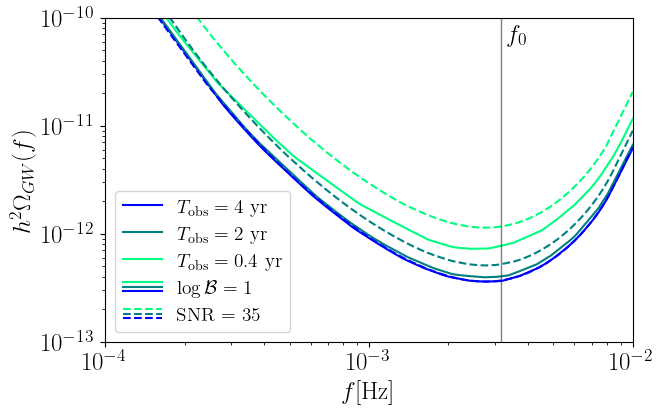

In [6]:
legend_plots = []
cmap = plt.get_cmap('winter')
db = cmap(0.0)   # Dark blue
teal = cmap(0.5)   # Teal
lg = cmap(1.0)  # Light green
bounds = [0.5, 1, 2]
rho = [34, 100, 1000]
plt.figure(figsize=rect_size)
for i in range(len(bounds)):
    if bounds[i] == 1:
        leg_a = plt.loglog(freq, pls_bayes_nu10[i][:],c = db, label = '$\log_{10}\mathcal{B} =$%.1f'%bounds[i])
        leg_b = plt.loglog(freq, pls_bayes_nu10_05nc[i][:],c = 'teal', label = '$\log_{10}\mathcal{B} =$%.1f'%bounds[i])
        leg_c = plt.loglog(freq, pls_bayes_nu10_01nc[i][:],c = lg, label = '$\log_{10}\mathcal{B} =$%.1f'%bounds[i])
for i in range(len(rho)):
    if rho[i] == 34:
        leg_d = plt.loglog(freq, pls_snr[i][:], c = db, linestyle = '--',label = 'SNR = %.1f'%rho[i])
        leg_e = plt.loglog(freq, pls_snr_nc05[i][:], c = 'teal', linestyle = '--',label = 'SNR = %.1f'%rho[i])
        leg_f = plt.loglog(freq, pls_snr_nc01[i][:], c = lg, linestyle = '--',label = 'SNR = %.1f'%rho[i])
legend_plots.append(leg_a)
legend_plots.append(leg_b)
legend_plots.append(leg_c)
legend_plots.append(leg_d)
legend_plots.append(leg_e)
legend_plots.append(leg_f)
plt.xlabel('$f \\rm{[Hz]}$')
plt.ylabel('$h^2\Omega_{GW}(f)$')
plt.axvline(10**-2.5, c = 'k',alpha = 0.5,linewidth=1)
plt.annotate("$f_0$", xy=(1.05*10**-2.5, 0.6*10**-10))
continuous_line = mlines.Line2D([], [], color='k', alpha = 0.5, label='$\log_{10}{\cal B} = 1$', linestyle='-')
dashed_line = mlines.Line2D([], [], color='k', alpha = 0.5, label='${\\rm SNR} = 35$', linestyle='--')
bpline = mlines.Line2D([], [], color=db, label='$T_{\\rm obs} = 4$ yr')
rpline = mlines.Line2D([], [], color='teal', label='$T_{\\rm obs} = 2$ yr')
gpline = mlines.Line2D([], [], color=lg, label='$T_{\\rm obs} = 0.4$ yr')
custom_lines_BF = [Line2D([0], [0], color=db, linestyle='-'),
                   Line2D([0], [0], color='teal', linestyle='-'),
                   Line2D([0], [0], color=lg, linestyle='-')]
custom_lines_SNR = [Line2D([0], [0], color=db, linestyle='--'),
                   Line2D([0], [0], color='teal', linestyle='--'),
                   Line2D([0], [0], color=lg, linestyle='--')]
plt.legend([bpline,
            rpline,
            gpline,
            (custom_lines_BF[0], custom_lines_BF[1], custom_lines_BF[2]),
            (custom_lines_SNR[0], custom_lines_SNR[1], custom_lines_SNR[2])],
          ["$T_{\\rm obs} = 4$ yr", 
           "$T_{\\rm obs} = 2$ yr",
           "$T_{\\rm obs} = 0.4$ yr",
           '$\log{\cal B} = 1$',
           'SNR = 35'], 
          handler_map={tuple: HandlerVerticalLines()}, 
          loc='lower left', fontsize=14)
plt.xlim(10**-4,10**-2)
plt.ylim(10**-13,10**-10)
plt.savefig('../../plots/pls_time.pdf',bbox_inches='tight')